# KL divergence and KSD of model

In [1]:
# Import packages
import torch
import numpy as np
from scipy import stats

import boltzgen as bg

from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
# Specify checkpoint root
checkpoint_root = '/draco/u/vstimper/Material_Informatics/boltzmann_generators/models/mcmc_01/'

In [3]:
# Load config
config = bg.utils.get_config(checkpoint_root + 'config/bm.yaml')

In [4]:
# Load data
training_data = bg.utils.load_traj('/draco/u/vstimper/Material_Informatics/boltzmann_generators/data/trajectory/aldp_without_const_100000.h5')

In [5]:
# Setup model
model = bg.BoltzmannGenerator(config)

# Move model on GPU if available
enable_cuda = False
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)
model = model.double()

In [ ]:
# Plot loss
loss = np.loadtxt(checkpoint_root + 'log/loss.csv')
plt.figure(figsize=(15, 10))
plt.plot(loss, '.')
plt.ylim(-190, -160)
plt.show()

In [ ]:
# Load checkpoint
model.load(checkpoint_root + 'checkpoints/model_30000.pt')

In [ ]:
# Draw samples

nth = 1

model.eval()

z_np = np.zeros((0, 60))
x_np = np.zeros((0, 66))
log_p_np = np.zeros((0,))
log_q_np = np.zeros((0,))

for i in tqdm(range(100 // nth)):
    z, log_q = model.sample(1000)
    x_np = np.concatenate((x_np, z.cpu().data.numpy()))
    log_p = model.p.log_prob(z)
    z, _ = model.flows[-1].inverse(z)
    z_np_ = z.cpu().data.numpy()
    log_p_np_ = log_p.cpu().data.numpy()
    log_q_np_ = log_q.cpu().data.numpy()
    z_np = np.concatenate((z_np, z_np_))
    log_p_np = np.concatenate((log_p_np, log_p_np_))
    log_q_np = np.concatenate((log_q_np, log_q_np_))


z_d = training_data[::nth].double().to(device)
log_p_d = model.p.log_prob(z_d)
z_d, _ = model.flows[-1].inverse(z_d)
z_d_np = z_d.cpu().data.numpy()

log_p_d_np = log_p_d.cpu().data.numpy()

## Use histogram to compute KLD

In [ ]:
# Estimate density
nbins = 200
hist_range = [-5, 5]
ndims = z_np.shape[1]

hists_train = np.zeros((nbins, ndims))
hists_gen = np.zeros((nbins, ndims))

for i in range(ndims):
    htrain, _ = np.histogram(z_d_np[:, i], nbins, range=hist_range, density=True);
    hgen, _ = np.histogram(z_np[:, i], nbins, range=hist_range, density=True);
    
    hists_train[:, i] = htrain
    hists_gen[:, i] = hgen

In [ ]:
for i in range(ndims):
    print(i)
    plt.plot(np.linspace(-5, 5, nbins), hists_train[:, i])
    plt.plot(np.linspace(-5, 5, nbins), hists_gen[:, i])
    plt.show()

In [ ]:
# Compute KLD
kld = np.zeros(ndims)
eps = 1e-10
kld_unscaled = np.sum(hists_train * np.log((hists_train + eps) / (hists_gen + eps)), axis=0)
kld = kld_unscaled * (hist_range[1] - hist_range[0]) / nbins

In [ ]:
# Split KLD into groups
ncarts = model.flows[-1].mixed_transform.len_cart_inds
permute_inv = model.flows[-1].mixed_transform.permute_inv
bond_ind = model.flows[-1].mixed_transform.ic_transform.bond_indices
angle_ind = model.flows[-1].mixed_transform.ic_transform.angle_indices
dih_ind = model.flows[-1].mixed_transform.ic_transform.dih_indices

kld_cart = kld[:(3 * ncarts - 6)]
kld_ = np.concatenate([kld[:(3 * ncarts - 6)], np.zeros(6), kld[(3 * ncarts - 6):]])
kld_ = kld_[permute_inv]
kld_bond = kld_[bond_ind]
kld_angle = kld_[angle_ind]
kld_dih = kld_[dih_ind]

In [ ]:
# Print resulting KLDs
print('Cartesian coorinates')
print(np.sort(kld_cart))
print('Mean:', np.mean(kld_cart))
print('Median:', np.median(kld_cart))

print('\n\nBond lengths')
print(np.sort(kld_bond))
print('Mean:', np.mean(kld_bond))
print('Median:', np.median(kld_bond))

print('\n\nBond angles')
print(np.sort(kld_angle))
print('Mean:', np.mean(kld_angle))
print('Median:', np.median(kld_angle))

print('\n\nDihedral angles')
print(np.sort(kld_dih))
print('Mean:', np.mean(kld_dih))
print('Median:', np.median(kld_dih))

In [ ]:
# Histograms of the groups
hists_train_cart = hists_train[:, :(3 * ncarts - 6)]
hists_train_ = np.concatenate([hists_train[:, :(3 * ncarts - 6)], np.zeros((nbins, 6)),
                               hists_train[:, (3 * ncarts - 6):]], axis=1)
hists_train_ = hists_train_[:, permute_inv]
hists_train_bond = hists_train_[:, bond_ind]
hists_train_angle = hists_train_[:, angle_ind]
hists_train_dih = hists_train_[:, dih_ind]

for hists in [hists_train_cart, hists_train_bond, hists_train_angle, hists_train_dih]:
    for i in range(hists.shape[1]):
        print(i)
        plt.plot(np.linspace(-5, 5, nbins), hists[:, i])
        plt.show()

## Use Gaussian KDE to compute KLD

In [ ]:
# Estimate density
ndims = z_np.shape[1]

kde_train = []
kde_gen = []

for i in range(ndims):
    kernel_train = stats.gaussian_kde(z_d_np[:, i])
    kernel_gen = stats.gaussian_kde(z_np[:, i])
    
    kde_train.append(kernel_train)
    kde_gen.append(kernel_gen)

In [ ]:
x = np.linspace(-5, 5, 200)
for i in range(ndims):
    print(i)
    plt.plot(x, kde_train[i].pdf(x))
    plt.plot(x, kde_gen[i].pdf(x))
    plt.show()

In [ ]:
# Compute KLD
eps = 1e-10
int_range = [-5, 5]
npoints = 1000

kld = np.zeros(ndims)
x = np.linspace(int_range[0], int_range[1], npoints)

for i in tqdm(range(ndims)):
    kld_unscaled = np.sum(kde_train[i].pdf(x) * np.log((kde_train[i].pdf(x) + eps) / (kde_gen[i].pdf(x) + eps)))
    kld[i] = kld_unscaled * (int_range[1] - int_range[0]) / npoints

In [ ]:
# Split KLD into groups
ncarts = model.flows[-1].mixed_transform.len_cart_inds
permute_inv = model.flows[-1].mixed_transform.permute_inv
bond_ind = model.flows[-1].mixed_transform.ic_transform.bond_indices
angle_ind = model.flows[-1].mixed_transform.ic_transform.angle_indices
dih_ind = model.flows[-1].mixed_transform.ic_transform.dih_indices

kld_cart = kld[:(3 * ncarts - 6)]
kld_ = np.concatenate([kld[:(3 * ncarts - 6)], np.zeros(6), kld[(3 * ncarts - 6):]])
kld_ = kld_[permute_inv]
kld_bond = kld_[bond_ind]
kld_angle = kld_[angle_ind]
kld_dih = kld_[dih_ind]

In [ ]:
# Print resulting KLDs
print('Cartesian coorinates')
print(np.sort(kld_cart))
print('Mean:', np.mean(kld_cart))
print('Median:', np.median(kld_cart))

print('\n\nBond lengths')
print(np.sort(kld_bond))
print('Mean:', np.mean(kld_bond))
print('Median:', np.median(kld_bond))

print('\n\nBond angles')
print(np.sort(kld_angle))
print('Mean:', np.mean(kld_angle))
print('Median:', np.median(kld_angle))

print('\n\nDihedral angles')
print(np.sort(kld_dih))
print('Mean:', np.mean(kld_dih))
print('Median:', np.median(kld_dih))

## Compute KSD

In [6]:
p = bg.distributions.TransformedBoltzmannParallel(model.system, config['system']['temperature'],
                                                  energy_cut=config['system']['energy_cut'],
                                                  energy_max=config['system']['energy_max'],
                                                  transform=model.flows[-1], n_threads=config['system']['n_threads'])

In [7]:
# Draw samples

num_samples = 1000000
batch_size = 1000

model.eval()

z_np = np.zeros((0, 60))
x_np = np.zeros((0, 66))
log_p_np = np.zeros((0,))
grad_log_p_np = np.zeros((0, 60))

for i in tqdm(range(num_samples // batch_size)):
    z, log_q = model.sample(batch_size)
    x_np = np.concatenate((x_np, z.cpu().data.numpy()))
    z, _ = model.flows[-1].inverse(z)
    z_ = z.detach().requires_grad_()
    log_p = p.log_prob(z_)
    grad_log_p = torch.autograd.grad(log_p, z_, grad_outputs=torch.ones_like(log_p))[0]
    z_np_ = z.cpu().data.numpy()
    log_p_np_ = log_p.cpu().data.numpy()
    grad_log_p_np_ = grad_log_p.cpu().data.numpy()
    z_np = np.concatenate((z_np, z_np_))
    log_p_np = np.concatenate((log_p_np, log_p_np_))
    grad_log_p_np = np.concatenate((grad_log_p_np, grad_log_p_np_))   

100%|██████████| 1000/1000 [2:03:22<00:00,  7.48s/it] 


In [8]:
# Calculate KSD
num_sub = 10

sub_length = num_samples // num_sub
median = bg.utils.get_median_estimate(z_np, 10000)
h_square = 0.5 * median / np.log(sub_length)

ksd = []

for i in tqdm(range(num_sub)):
    ksd_ = bg.utils.blockKSD(z_np[(sub_length * i):(sub_length * (i + 1))],
                             grad_log_p_np[(sub_length * i):(sub_length * (i + 1))], 
                             10, h_square)
    ksd.append(ksd_)
    print(ksd_)

ksd = np.array(ksd)
np.save('/draco/u/vstimper/Material_Informatics/boltzmann_generators/results/ksd/mcmc_01.npy', ksd)

 10%|█         | 1/10 [14:27<2:10:10, 867.80s/it]

0.00026107545515511704


 20%|██        | 2/10 [29:54<1:58:04, 885.60s/it]

0.00026032295366813703


 30%|███       | 3/10 [46:49<1:47:49, 924.20s/it]

0.0002678105028262927


 40%|████      | 4/10 [1:03:17<1:34:20, 943.40s/it]

0.00025900611968465226


 50%|█████     | 5/10 [1:19:41<1:19:38, 955.76s/it]

0.00027220019281640315


 60%|██████    | 6/10 [1:35:15<1:03:15, 948.97s/it]

0.0002710331891520657


 70%|███████   | 7/10 [1:51:38<47:57, 959.26s/it]  

0.000262497762161073


 80%|████████  | 8/10 [2:06:57<31:34, 947.19s/it]

0.0002571419561923477


 90%|█████████ | 9/10 [2:23:45<16:05, 965.60s/it]

0.0002681792371684422


100%|██████████| 10/10 [2:39:20<00:00, 956.34s/it]

0.00026969471304943196


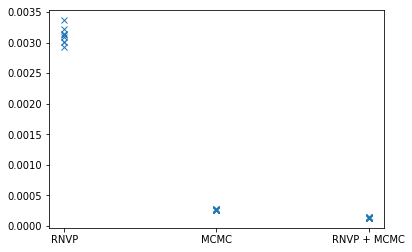

In [11]:
ksd_rnvp = np.load('/draco/u/vstimper/Material_Informatics/boltzmann_generators/results/ksd/rnvp_01.npy')
ksd_snf = np.load('/draco/u/vstimper/Material_Informatics/boltzmann_generators/results/ksd/snf_01.npy')
ksd_mcmc = np.load('/draco/u/vstimper/Material_Informatics/boltzmann_generators/results/ksd/mcmc_01.npy')

#plt.figure(figsize=(10, 10))
plt.plot(['RNVP'] * 10 + ['MCMC'] * 10 + ['RNVP + MCMC'] * 10, np.concatenate([ksd_rnvp, ksd_mcmc, ksd_snf]), 'x')
#plt.plot(['MCMC'] * 10 + ['RNVP + MCMC'] * 10, np.concatenate([ksd_mcmc, ksd_snf]), 'x')
plt.savefig('ksd_with_rnvp.png', dpi=300)
plt.show()